# Importing Modules

In [1]:
import torch
import torchinfo
import torchvision
import pickle

import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
import models

In [3]:
import importlib
importlib.reload(models)

<module 'models' from 'c:\\Users\\josep\\Code\\School\\RL\\Project\\src\\models\\__init__.py'>

# DQN

## Configure

In [4]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


In [5]:
GRID_SEARCH = True

In [6]:
def save_model(agent, path: str):
    """Save DQN model weights"""
    with open(path, 'wb') as file:
        pickle.dump(agent, file)
    

def load_model(path: str):
    """Load DQN model weights"""
    with open(path, 'rb') as f:
        model = pickle.load(f)
    return model

## Hyperparameters search

In [ ]:
if GRID_SEARCH:
    tuner = models.RayTuneDQN(num_samples=50, max_episodes=1000)

    # Run hyperparameter search
    analysis = tuner.run_hyperparameter_search()

    # Print best configuration
    best_dqn = tuner.print_best_config(analysis)

In [8]:
if not GRID_SEARCH:
    best_dqn = {'memory_size': 10000, 'batch_size': 256, 'epsilon_start': 0.9694537402207997, 'epsilon_min': 0.05777994380661172, 'epsilon_decay': 2000, 'tau': 0.002242904067378243, 'gamma': 0.9784207007863884, 'learning_rate': 0.000134011886912442}

In [9]:
print("Best trial config:", best_dqn)

Best trial config: {'memory_size': 10000, 'batch_size': 256, 'epsilon_start': 0.9694537402207997, 'epsilon_min': 0.05777994380661172, 'epsilon_decay': 2000, 'tau': 0.002242904067378243, 'gamma': 0.9784207007863884, 'learning_rate': 0.000134011886912442}


In [10]:
N_EPOCHS = 1000
MODEL_PATH = './best_model.pth'

## Train

In [11]:
env = gym.make("CartPole-v1")
env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = models.CartPoleDQNAgent(env, state_dim, action_dim, device, 
                            **best_dqn)

In [12]:
# Train the agent
tr_info = models.train_DQL(env, agent, device, int(N_EPOCHS))


100%|██████████| 1000/1000 [23:47<00:00,  1.43s/it, total_r=500]


## Save best model

In [13]:
save_model(agent, './best_dqn.pkl')

## Load best model

In [14]:
load_model('./best_dqn.pkl')

## Plot result

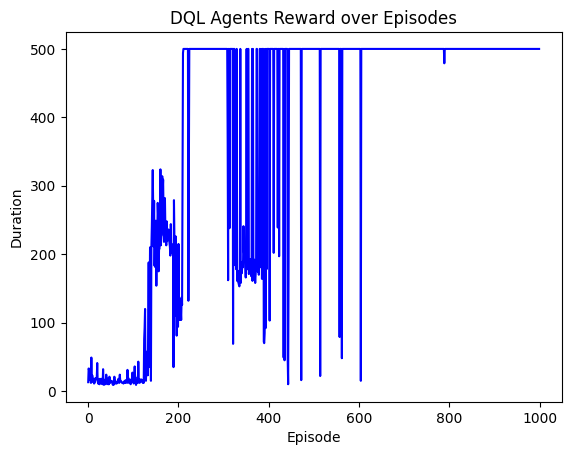

In [15]:
plt.figure(1)
plt.title('DQL Agents Reward over Episodes')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(tr_info['total_r'], color='b')
plt.show()

# DDQN

## Configure

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'

In [23]:
GRID_SEARCH = True
N_EPOCHS = 1000
MODEL_PATH = './best_model.pth'

## Hyperparameter search

In [24]:
if GRID_SEARCH:
    tuner = models.RayTuneDDQN(num_samples=50, max_episodes=1000)

    # Run hyperparameter search
    analysis = tuner.run_hyperparameter_search()


2024-12-12 14:56:01,440	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\josep\AppData\Local\Temp\ray\session_2024-12-12_14-55-55_898340_37316\artifacts\2024-12-12_14-56-01\_trainable_2024-12-12_14-56-01\driver_artifacts\_trainable_1cdab_00000_0_batch_size=128,epsilon_decay=9000,epsilon_min=0.0013,epsilon_start=0.9854,gamma=0.9870,learning_rate=0.00_2024-12-12_14-56-01
2024-12-12 14:56:01,443	WARNING trial.py:647 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\josep\AppData\Local\Temp\ray\session_2024-12-12_14-55-55_898340_37316\artifacts\2024-12-12_14-56-01\_trainable_2024-12-12_14-56-01\driver_artifacts\_trainable_1cdab_00000_0_batch_size=128,epsilon_decay=9000,epsilon_min=0.0013,epsilon_start=0.9854,gamma=0.9870,learning_rate=0.00_2024-12-12_14-56-01
2024-12-12 14:56:01,448	

In [26]:
if GRID_SEARCH: 
    # Print best configuration
    best_ddqn = tuner.print_best_config(analysis)

AttributeError: 'numpy.float64' object has no attribute 'loc'

In [16]:
if not GRID_SEARCH:
    best_ddqn = {'memory_size': 20000, 'batch_size': 64, 'epsilon_start': 0.9597620440201929, 'epsilon_min': 0.03331095591947606, 'epsilon_decay': 2000, 'tau': 0.005379493685319799, 'gamma': 0.9800696038043265, 'learning_rate': 0.00013099458218967787}

## Train

In [17]:
env = gym.make("CartPole-v1")
env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = models.CartPoleDDQNAgent(env, state_dim, action_dim, device, 
                            **best_ddqn)

In [18]:
# Train the agent
tr_info = models.train_DDQL(env, agent, device, N_EPOCHS)

100%|██████████| 1000/1000 [10:26<00:00,  1.60it/s, total_r=500]


## Plot

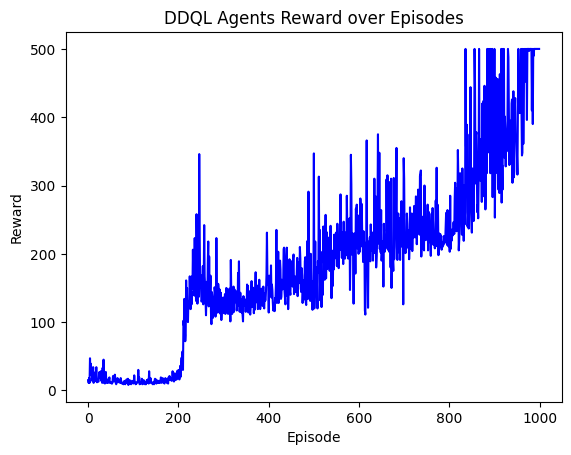

In [19]:
plt.figure(1)
plt.title('DDQL Agents Reward over Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(tr_info['total_r'], color='b')
plt.show()

## Save best model

In [12]:
save_model(agent, './best_ddqn.pkl')

NameError: name 'save_model' is not defined

## Load best model

In [24]:
load_model('./best_ddqn.pkl')